# CasTex

Ссылка на проект: [страница проекта](https://thecrazymage.github.io/CasTex/).

## Установка предварительных зависимостей и импорт

In [1]:
!git clone https://github.com/thecrazymage/DL2_HSE
%cd /content/DL2_HSE/week_10/seminar
!ls

Cloning into 'DL2_HSE'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 284 (delta 69), reused 80 (delta 17), pack-reused 110 (from 1)
Receiving objects: 100% (284/284), 136.01 MiB | 21.06 MiB/s, done.
Resolving deltas: 100% (97/97), done.
Updating files: 100% (52/52), done.
/content/DL2_HSE/week_10/seminar
bsdf_256_256.bin  mud_road_puresky_1k.hdr  our_kaolin.py  spot.obj  utils.py


In [ ]:
!pip install xatlas
!pip install --upgrade git+https://github.com/NVlabs/nvdiffrast@v0.3.4
!pip install envlight
!pip install -U -q bitsandbytes

# It works in the next Colab specification (https://research.google.com/colaboratory/runtime-version-faq.html#2025.07):
# Ubuntu 22.04.04 LTS
# Python 3.11.13
# numpy 2.0.2
# PyTorch 2.6.0
# Jax 0.5.2
# Tensorflow 2.18.0 (not included in TPU runtimes)
# R version 4.5.1 (2025-06-13) -- "Great Square Root"
# julia version 1.10.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 9.2 MB/s eta 0:00:00
  Cloning https://github.com/NVlabs/nvdiffrast to /tmp/pip-req-build-vtfpt2z4
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/nvdiffrast /tmp/pip-req-build-vtfpt2z4
  Resolved https://github.com/NVlabs/nvdiffrast to commit abb07ca0358f3a21c3942b50c54aa1eacd329af9
  Preparing metadata (setup.py) ... done
  Created wheel for nvdiffrast: filename=nvdiffrast-0.3.4-py3-none-any.whl size=140146 sha256=16eae5ca2086d5d419510bd903a2142a3542223a559a7de4976a93dd7fbf2fb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-7uvikifq/wheels/a9/26/25/532e556eb7ea2d01c41a6775926649dee9fb46d020b69d05a0
Successfully built nvdiffrast
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.0 MB/s eta 0:00:00


In [3]:
import gc
import os
import cv2
import copy
import math
import torch
import xatlas
import imageio
import envlight
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
from torch.nn import Parameter, ParameterDict

import matplotlib.pylab as plt
from IPython.display import Video
from diffusers import DiffusionPipeline
from transformers import T5EncoderModel
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings('ignore')

In [4]:
def flush():
    gc.collect()
    torch.cuda.empty_cache()

flush()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Your device - {device}!")

Your device - cuda:0!


In [5]:
from huggingface_hub import login

login(token="your token")

## Обработка промптов

In [6]:
deepfloyd_model = "DeepFloyd/IF-I-M-v1.0"

text_encoder = T5EncoderModel.from_pretrained(
    deepfloyd_model,
    subfolder="text_encoder",
    load_in_8bit=True,
    variant="8bit",
)
pipe = DiffusionPipeline.from_pretrained(
    deepfloyd_model,
    text_encoder=text_encoder, # pass the previously instantiated 8bit text encoder
    unet=None,
    device_map="balanced"
)

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


text_encoder/model.8bit.safetensors:   0%|          | 0.00/7.92G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

watermarker/diffusion_pytorch_model.bin:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--DeepFloyd--IF-I-M-v1.0/snapshots/64dfba780d63640fda95964acba4f410e0420d5f/watermarker: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--DeepFloyd--IF-I-M-v1.0/snapshots/64dfba780d63640fda95964acba4f410e0420d5f/watermarker.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
prompt = "A cow made of wood"
directions = ['front view', 'side view', 'top view', 'backside view']
directional_prompts = [prompt + ', ' + direction for direction in directions]

prompt_embeddings = pipe.encode_prompt(prompt)
directional_prompt_embeddings = pipe.encode_prompt(directional_prompts)

embeddings_dict = {
    'base_prompt': prompt_embeddings,
    'directional_prompts': directional_prompt_embeddings,
    'directions': directions,
    'text_versions': {
        'base': prompt,
        'directional': directional_prompts
    }
}

filename = f'embeddings_dict_{prompt.replace(" ", "_")}.pt'
torch.save(embeddings_dict, filename)


In [8]:
del text_encoder
del pipe
flush()

## Работа с моделью

### Загрузка

In [9]:
from our_kaolin import import_mesh, center_points, PBRMaterial, SurfaceMesh

def load_mesh(filename, pbr_material_parameters, use_predefined_texture=False, device="cuda:0"):

    mesh = import_mesh(filename, with_materials=use_predefined_texture)
    mesh = mesh.to(device=device)
    # центрируем и переводим в [-1,1]^3
    mesh.vertices = 2 * center_points(
        mesh.vertices.unsqueeze(0), normalize=True
    ).squeeze(0)

    if use_predefined_texture:
        uvs = mesh.uvs
        indices = mesh.face_uvs_idx
    else:
        vmapping, indices, uvs = xatlas.parametrize(
            mesh.vertices.cpu(),
            mesh.faces.cpu(),
        )
        uvs = torch.tensor(uvs)
        indices = torch.tensor(indices.astype(np.int64), dtype=torch.long)

    my_material = PBRMaterial(
        **pbr_material_parameters,
        is_specular_workflow=False
    )
    # для подсчета BRDF
    FG_LUT = torch.from_numpy(
        np.fromfile("bsdf_256_256.bin", dtype=np.float32).reshape(
            1, 256, 256, 2
        )
    ).cuda()
    my_material.FG_LUT = FG_LUT

    return SurfaceMesh(
        vertices=mesh.vertices,
        faces=mesh.faces,
        uvs=uvs.to(device),
        face_uvs_idx=indices.to(device),
        materials=[my_material,],
        allow_auto_compute=True
    )

def copy_mesh(mesh, texture):
    texture_clone = {key: texture[key].detach().clone() for key in texture.keys()}
    my_material = PBRMaterial(
        **texture_clone,
        is_specular_workflow=False
    )
    new_mesh = copy.copy(mesh)
    new_mesh.materials = [my_material, ]
    my_material.FG_LUT = mesh.materials[0].FG_LUT
    return new_mesh

Инициализация PBR-параметров

diffuse: основной цвет (RGB)
normals: карта нормалей для микрорельефа (XYZ в тангенс-пространстве)
metallic: насколько материал металлический (0-1)
roughness: шероховатость поверхности (0-1)

In [10]:
mesh_path = 'spot.obj'
texture_dim = 1024

pbr_params = ParameterDict({
    'diffuse_texture': Parameter(torch.full((texture_dim, texture_dim, 3), 0.5, device=device)),
    'normals_texture': Parameter(
        torch.cat([
            torch.zeros((texture_dim, texture_dim, 2), device=device),
            torch.ones((texture_dim, texture_dim, 1), device=device)
        ], dim=-1)
    ),
    'metallic_texture': Parameter(torch.full((texture_dim, texture_dim, 1), 0.1, device=device)),
    'roughness_texture': Parameter(torch.full((texture_dim, texture_dim, 1), 0.5, device=device)),
})

mesh = load_mesh(mesh_path, pbr_params, use_predefined_texture=False, device=device)

print(f"Загружена модель '{mesh_path}':")
print(f"\tВершин: {mesh.vertices.shape[0]}")
print(f"\tГраней: {mesh.faces.shape[0]}")
print(f"\tUV координат: {mesh.uvs.shape[0]}")


Загружена модель 'spot.obj':
	Вершин: 2930
	Граней: 5856
	UV координат: 3638


### Камеры

In [12]:
from utils import Camera

def generate_point_on_a_sphere(shape):
    theta = torch.pi / 3 * (2. * torch.rand(*shape) - 1.)
    phi = 2 * torch.pi * torch.rand(*shape)
    return torch.stack([
        phi.cos() * theta.cos(),
        theta.sin(),
        phi.sin() * theta.cos()
    ], -1), theta, phi


def get_camera(batch_size, target, r, eye=None, device='cuda:0'):
    if eye is None:
        eye, theta, phi = generate_point_on_a_sphere([batch_size,])
        eye = r * eye
    else:
        theta, phi = None, None

    eye = eye.to(device)                                        # позиция камеры
    target = target.to(device)                                  # куда камера смотрит
    up = torch.tensor([0.0, 1.0, 0.0], device=device)           # где у камеры вверх
    fov = torch.full_like(eye[..., 0], 30 * torch.pi / 180)     # поле зрения камеры

    return Camera(eye=eye, at=target, up=up, fov=fov, width=256, height=256), theta, phi

def get_camera_parameters():
    camera_target = torch.tensor([0., 0., 0.])
    r = 2 * torch.tensor(2.2)
    return camera_target, r

In [13]:
d2n = {
    0 : 'front view',
    1 : 'side view',
    2 : 'backside view',
    3 : 'top view',
    4 : 'bottom view',
}

def get_view_direction(thetas, phis):
    '''
    Classifies camera positions into different views:
    0 - front view, 1 - side view, 2 - backside view, 3 - top view, 4 - bottom view
    '''
    res = torch.zeros(thetas.shape[0], dtype=torch.long)
    phis = phis % (2 * torch.pi)
    thetas = thetas % (2 * torch.pi)

    # Front view: phi in [pi/4, 3pi/4]
    front_mask = (phis >= torch.pi / 4) & (phis <= 3 * torch.pi / 4)

    # Backside view: phi in [5pi/4, 7pi/4]
    backside_mask = (phis >= 5 * torch.pi / 4) & (phis <= 7 * torch.pi / 4)

    # Side view: phi in (-pi/4, pi/4) or (3pi/4, 5pi/4)
    side_mask = ((phis > 7 * torch.pi / 4) | (phis < torch.pi / 4)) | ((phis > 3 * torch.pi / 4) & (phis < 5 * torch.pi / 4))

    # Top view: theta in [pi/4, 3pi/4]
    top_mask = (thetas >= torch.pi / 4) & (thetas <= 3 * torch.pi / 4)

    # Bottom view: theta in [5pi/4, 7pi/4]
    bottom_mask = (thetas >= 5 * torch.pi / 4) & (thetas <= 7 * torch.pi / 4)

    res[front_mask] = 0
    res[side_mask] = 1
    res[backside_mask] = 2
    res[top_mask] = 3
    res[bottom_mask] = 4

    return res

In [14]:
camera_target, r = get_camera_parameters()

camera_phis = torch.Tensor(([0.5 * math.pi * (0.5 + i) for i in range(4)]))#.view(1, -1)
camera_thetas = torch.Tensor(4 * [0,])

val_eye = r * torch.stack([
    camera_phis.cos() * camera_thetas.cos(),
    torch.ones_like(camera_phis) * camera_thetas.sin(),
    camera_phis.sin() * camera_thetas.cos()
], dim=-1).view(-1, 3)
camera, _, _ = get_camera(len(val_eye), camera_target, r, eye=val_eye, device=device)

### Освещение

In [16]:
light = envlight.EnvLight(
    'mud_road_puresky_1k.hdr',
    scale=2.0,
    device=device
)

### Рендер

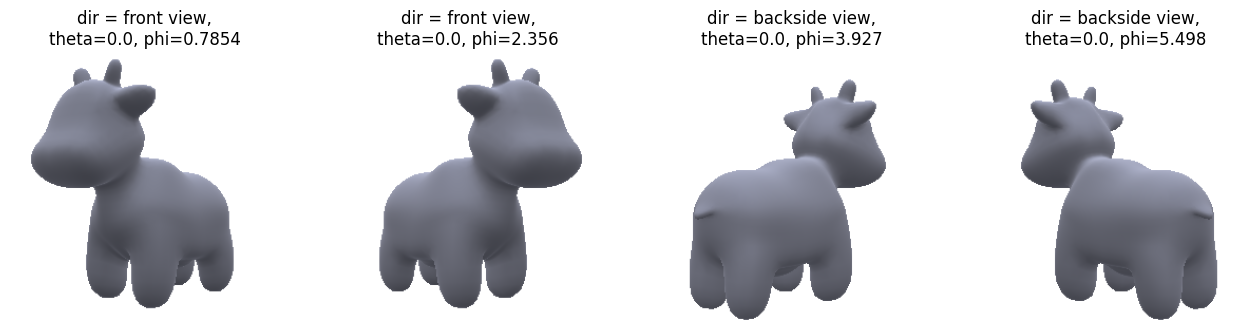

In [17]:
from utils import render

image = render(mesh, camera, light, val_background=True)
view_dirs = get_view_direction(camera_thetas, camera_phis)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(image[i].clamp(0., 1.).detach().cpu())
    ax.set_title(f"dir = {d2n[view_dirs[i].item()]},\ntheta={camera_thetas[i]:.4}, phi={camera_phis[i]:.4}")
    ax.axis('off')

## Обучение текстуры

### SDS

In [18]:
class SDSLoss(torch.nn.Module):

    STAGE_MODELS = {
        'i': 'DeepFloyd/IF-I-M-v1.0',
        'ii': 'DeepFloyd/IF-II-M-v1.0',
    }

    def __init__(
        self,
        stage='i',
        device='cuda:0',
    ):
        super().__init__()

        self.device = device
        self.stage = stage
        self.resolution = (64, 64) if stage == 'i' else (256, 256)
        model_name = self.STAGE_MODELS[stage]

        pipe = DiffusionPipeline.from_pretrained(
            model_name,
            text_encoder=None,
            safety_checker=None,
            watermarker=None,
            feature_extractor=None,
            requires_safety_checker=False,
            variant="fp16",
            torch_dtype=torch.float16,
        ).to(self.device)

        self.unet = pipe.unet.eval()
        self.scheduler = pipe.scheduler
        self.num_train_timesteps = self.scheduler.config.num_train_timesteps
        self.alphas = self.scheduler.alphas_cumprod.to(self.device)

    @torch.amp.autocast('cuda', enabled=False)
    def forward_unet(self, latents, t, encoder_hidden_states, **kwargs):
        return self.unet(
            latents.to(torch.float16),
            t.to(torch.float16),
            encoder_hidden_states.to(torch.float16),
            **kwargs
        ).sample.to(latents.dtype)

    def prepare_latents(self, images):
        latents = F.interpolate(
            images,
            self.resolution,
            mode="bilinear",
            align_corners=False,
            antialias=True
        )
        return 2.0 * latents - 1.0

    def prepare_condition(self, images, lowres_noise_level):
        """ Only for stage ii """
        downscaled = F.interpolate(images, (64, 64), mode="nearest")
        upscaled = F.interpolate(downscaled, (256, 256), mode="nearest")
        upscaled = 2.0 * upscaled - 1.0
        upscaled = self.scheduler.add_noise(
            upscaled,
            torch.randn_like(upscaled),
            torch.tensor(int(self.num_train_timesteps * lowres_noise_level))
        )
        return upscaled

    def predict_noise(self, latents_noisy, t, prompt_embeddings, guidance_scale, original, lowres_noise_level):

        batch_size = latents_noisy.shape[0]

        kwargs = {}
        if self.stage == 'ii':
            condition = self.prepare_condition(original, lowres_noise_level)
            condition = self.scheduler.scale_model_input(condition, t)
            noise_level = torch.full(
                    [2 * batch_size],
                    torch.tensor(int(self.num_train_timesteps * lowres_noise_level)),
                    device=self.device
            )
            latents_noisy = torch.cat([latents_noisy, condition], dim=1)
            kwargs = {'class_labels' : noise_level}

        # conditional/unconditional prediction
        latent_model_input = torch.cat([latents_noisy] * 2)
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

        noise_pred = self.forward_unet(
            latent_model_input,
            t.repeat(2 * batch_size),
            torch.cat(prompt_embeddings),  # [positive, negative]
            **kwargs
        )

        # CFG: uncond + scale * (cond - uncond)
        noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
        noise_pred_text, predicted_variance = noise_pred_text.split(3, dim=1)
        noise_pred_uncond, _ = noise_pred_uncond.split(3, dim=1)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        return noise_pred

    def get_denoised_latents(self, latents_noisy, noise_pred, t, clip=True):
        """ x0 = (x_t - sqrt(1 - alpha_t) * noise) / sqrt(alpha_t) """
        alpha_t = self.alphas[t]
        beta_t = 1 - alpha_t
        x0 = (latents_noisy - noise_pred * beta_t.sqrt()) / alpha_t.sqrt()
        if clip:
            x0 = x0.clamp(-1.0, 1.0)
        return x0

    def forward(
        self,
        images,
        prompt_embeddings,
        min_step=200,
        max_step=900,
        guidance_scale=15.0,
        original=None,
        lowres_noise_level=0.5,  # for stage ii
    ):
        batch_size = images.shape[0]

        latents = self.prepare_latents(images)
        t = torch.randint(
            min_step,
            max_step,
            [1],
            dtype=torch.long,
            device=self.device
        )

        with torch.no_grad():
            noise = torch.randn_like(latents, device=self.device)
            latents_noisy = self.scheduler.add_noise(latents, noise, t)

            noise_pred = self.predict_noise(
                latents_noisy,
                t,
                prompt_embeddings,
                guidance_scale,
                original,
                lowres_noise_level
            )

            latents_denoised = self.get_denoised_latents(
                latents_noisy,
                noise_pred,
                t,
                clip=True
            )


        w = ((1 - self.alphas[t]) * self.alphas[t]).sqrt().view(-1, 1, 1, 1)
        loss_sds = 0.5 * w * F.mse_loss(latents, latents_denoised, reduction="sum") / batch_size

        return loss_sds

### Функция обучения

In [19]:
def train_texture(
    mesh,
    pbr_params,
    prompt_embeddings,
    stage='i',
    n_iterations=1000,
    learning_rate=0.01,
    batch_size=8,
    val_print_epoch=100,
    min_step=200,
    max_step=900,
    guidance_scale=15.0,
    mesh_original=None,           # для stage ii
    lowres_noise_level=0.5,       # для stage ii
    device='cuda:0'
):

    sds_loss = SDSLoss(stage=stage, device=device)
    optimizer = torch.optim.Adam(pbr_params.parameters(), lr=learning_rate)

    batch_embeddings = [
        prompt_embeddings[0].repeat(batch_size, 1, 1),
        prompt_embeddings[1].repeat(batch_size, 1, 1)
    ]

    camera_target, r = get_camera_parameters()
    min_radius_scale = 0.5
    max_radius_scale = 1.5

    for iteration in tqdm(range(n_iterations), desc=f"Training stage {stage}"):

        rand_scale = torch.rand(1) * (max_radius_scale - min_radius_scale) + min_radius_scale
        camera, camera_thetas, camera_phis = get_camera(batch_size, camera_target, rand_scale * r)

        background = torch.rand(3, device=device)
        rendered = render(mesh, camera, light, random_background=background)
        images = torch.movedim(rendered, -1, 1)  # [B, H, W, C] -> [B, C, H, W]

        optimizer.zero_grad()

        if stage == 'i':
            loss = sds_loss(
                images,
                batch_embeddings,
                min_step=min_step,
                max_step=max_step,
                guidance_scale=guidance_scale
            )
        elif stage == 'ii':
            original = render(mesh_original, camera, light, random_background=background)
            original = torch.movedim(original, -1, 1)  # [B, H, W, C] -> [B, C, H, W]
            loss = sds_loss(
                images,
                batch_embeddings,
                min_step=min_step,
                max_step=max_step,
                guidance_scale=guidance_scale,
                original=original,
                lowres_noise_level=lowres_noise_level
            )

        loss.backward()
        optimizer.step()

        # Клэмпинг параметров текстур
        with torch.no_grad():
            pbr_params['diffuse_texture'].data.clamp_(0., 1.)
            pbr_params['metallic_texture'].data.clamp_(0., 1.)
            pbr_params['roughness_texture'].data.clamp_(0., 1.)
            pbr_params['normals_texture'].data = F.normalize(
                pbr_params['normals_texture'].data,
                dim=-1
            )

        # Визуализация
        if iteration % val_print_epoch == 0:
            with torch.no_grad():
                camera, camera_thetas, camera_phis = get_camera(batch_size, camera_target, r)
                image = render(mesh, camera, light, val_background=True)
                view_dirs = get_view_direction(camera_thetas, camera_phis)

                fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
                for i, ax in enumerate(axes.flat):
                    ax.imshow(image[i].clamp(0., 1.).detach().cpu())
                    ax.set_title(f"dir = {d2n[view_dirs[i].item()]},\ntheta={camera_thetas[i]:.4}, phi={camera_phis[i]:.4}")
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

    del sds_loss
    flush()
    return mesh, pbr_params

### Обучение (i)

In [20]:
mesh_path = 'spot.obj'
texture_dim = 512

pbr_params = ParameterDict({
    'diffuse_texture': Parameter(torch.full((texture_dim, texture_dim, 3), 0.5, device=device)),
    'normals_texture': Parameter(
        torch.cat([
            torch.zeros((texture_dim, texture_dim, 2), device=device),
            torch.ones((texture_dim, texture_dim, 1), device=device)
        ], dim=-1)
    ),
    'metallic_texture': Parameter(torch.full((texture_dim, texture_dim, 1), 0.1, device=device)),
    'roughness_texture': Parameter(torch.full((texture_dim, texture_dim, 1), 0.5, device=device)),
})

mesh = load_mesh(mesh_path, pbr_params, use_predefined_texture=False, device=device)


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/pytorch_model.bin.index.fp16.json, text_encoder/model.safetensors.index.fp16.json, text_encoder/model.fp16-00001-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/743M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Training stage i:   0%|          | 0/500 [00:00<?, ?it/s]

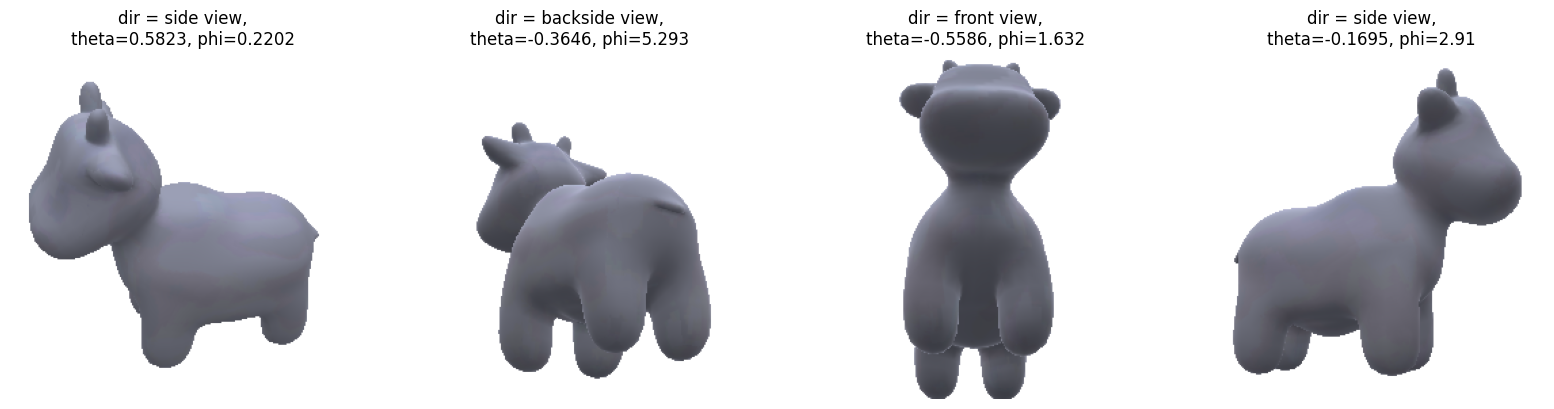

Training stage i:  10%|█         | 50/500 [00:18<02:33,  2.92it/s]

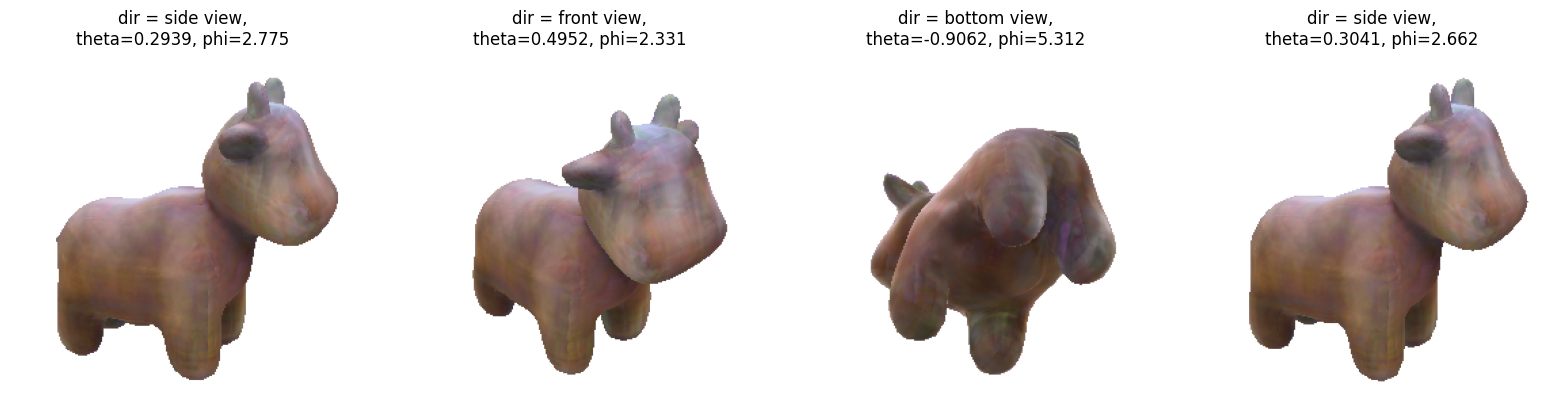

Training stage i:  20%|██        | 100/500 [00:35<02:19,  2.87it/s]

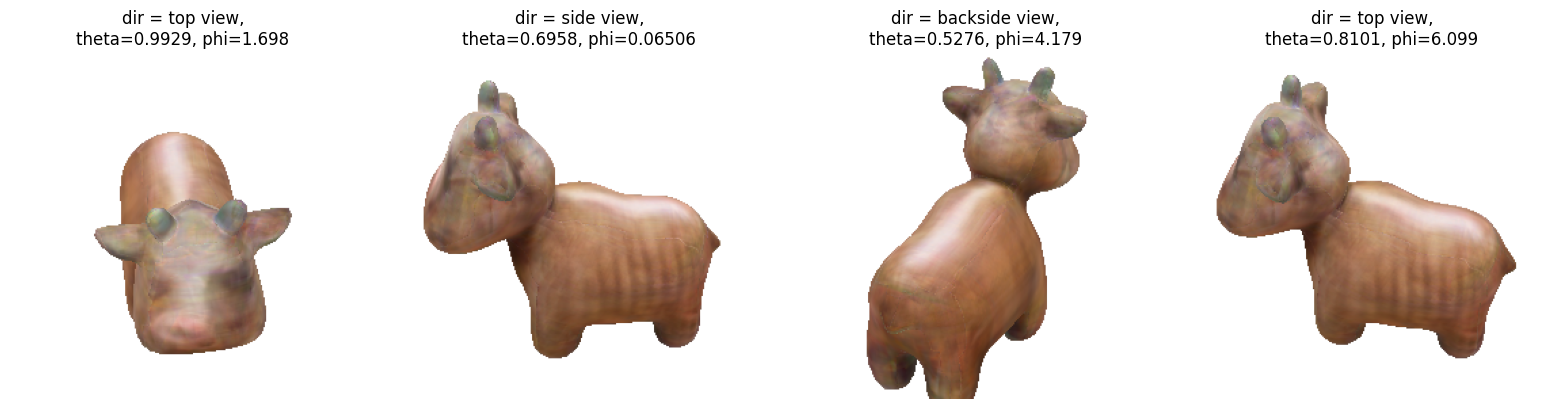

Training stage i:  30%|███       | 150/500 [00:53<01:57,  2.98it/s]

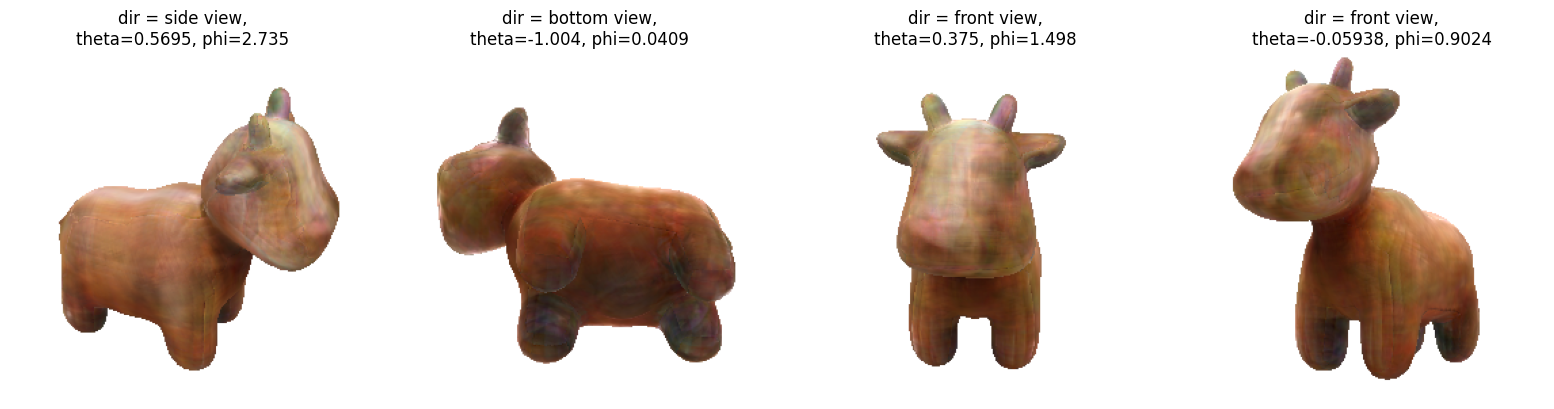

Training stage i:  40%|████      | 200/500 [01:10<01:39,  3.01it/s]

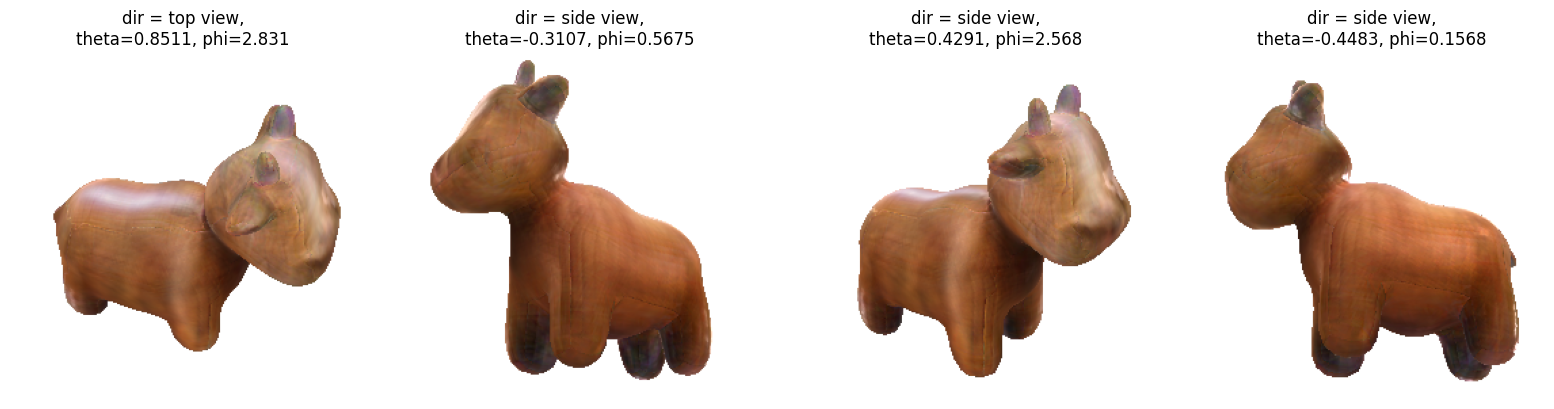

Training stage i:  50%|█████     | 250/500 [01:27<01:23,  3.00it/s]

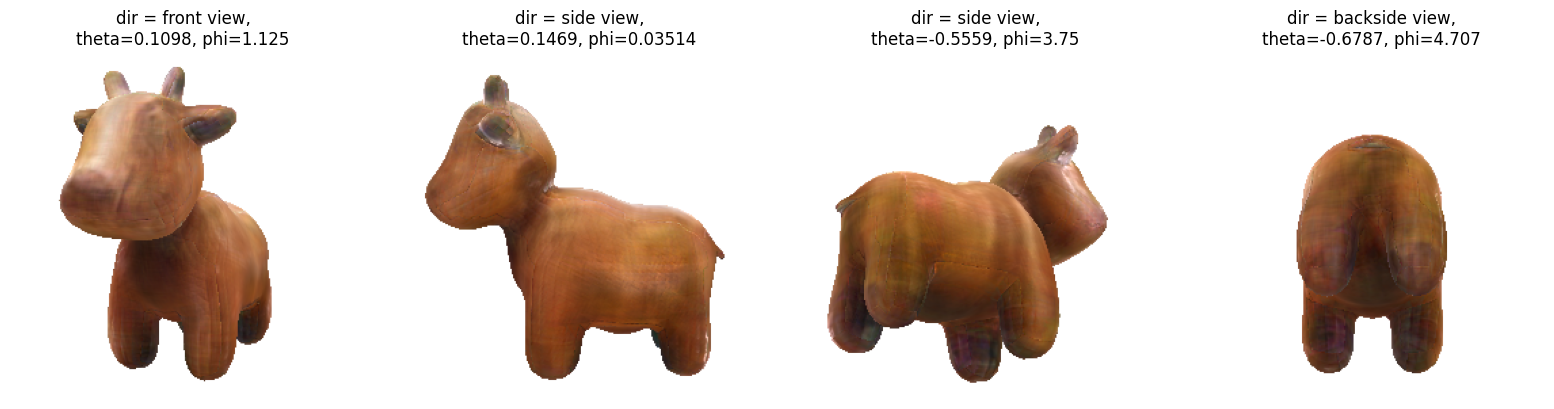

Training stage i:  60%|██████    | 300/500 [01:44<01:07,  2.97it/s]

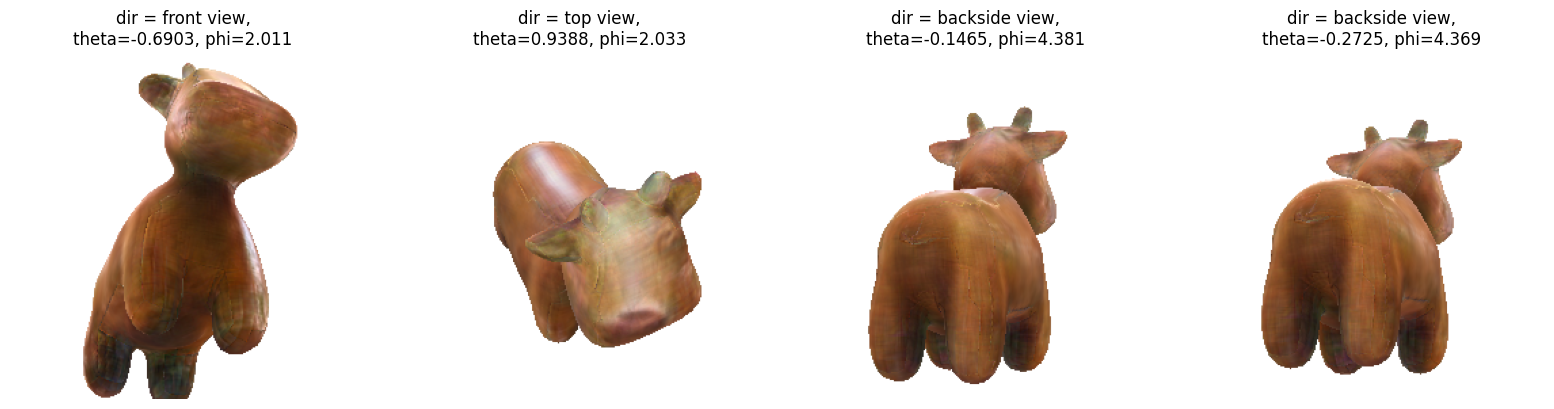

Training stage i:  70%|███████   | 350/500 [02:01<00:51,  2.93it/s]

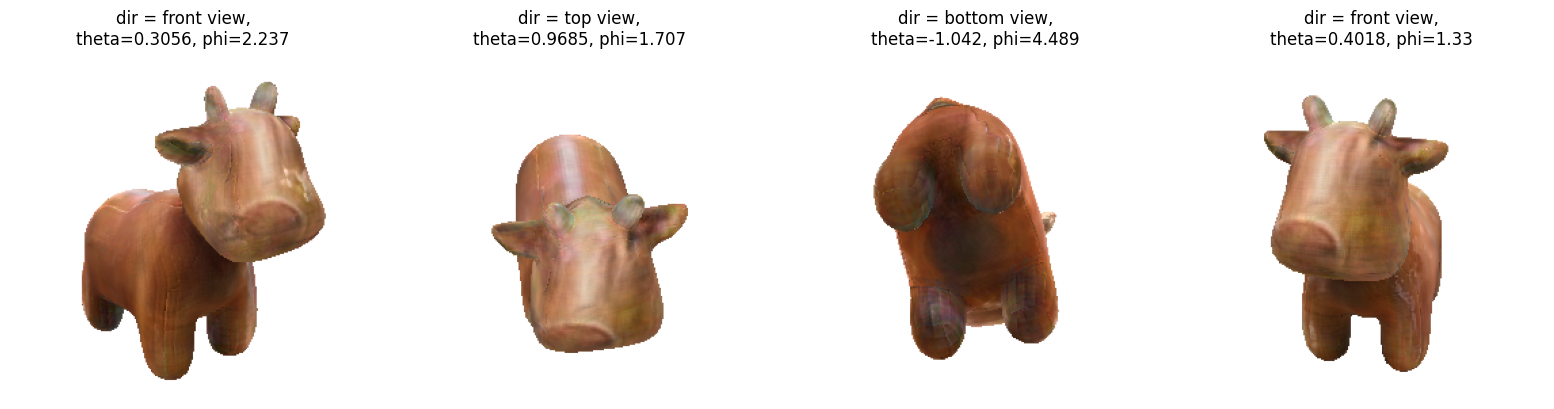

Training stage i:  80%|████████  | 400/500 [02:19<00:33,  2.97it/s]

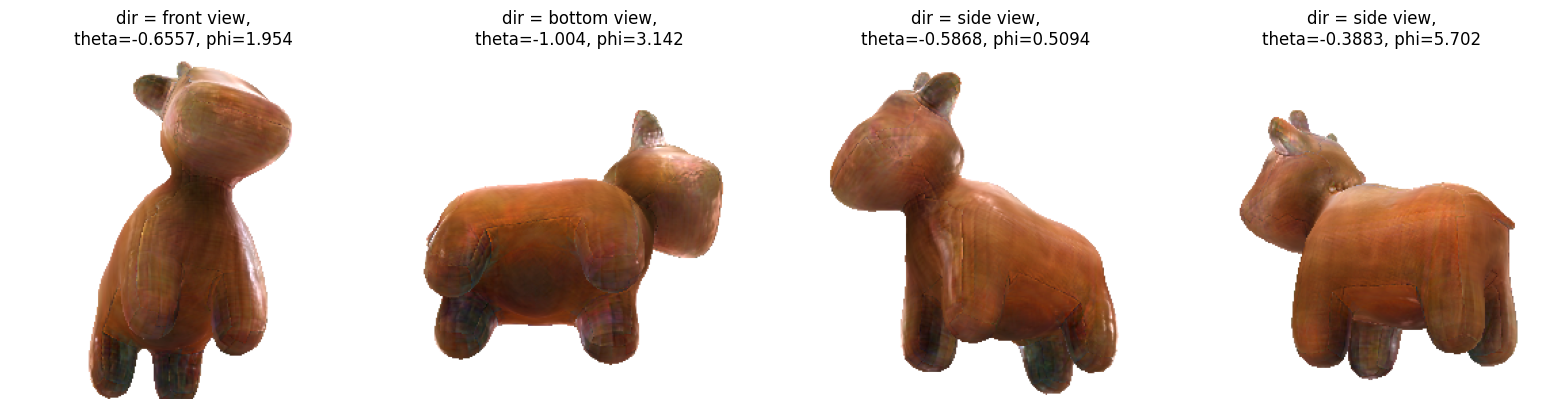

Training stage i:  90%|█████████ | 450/500 [02:36<00:16,  2.98it/s]

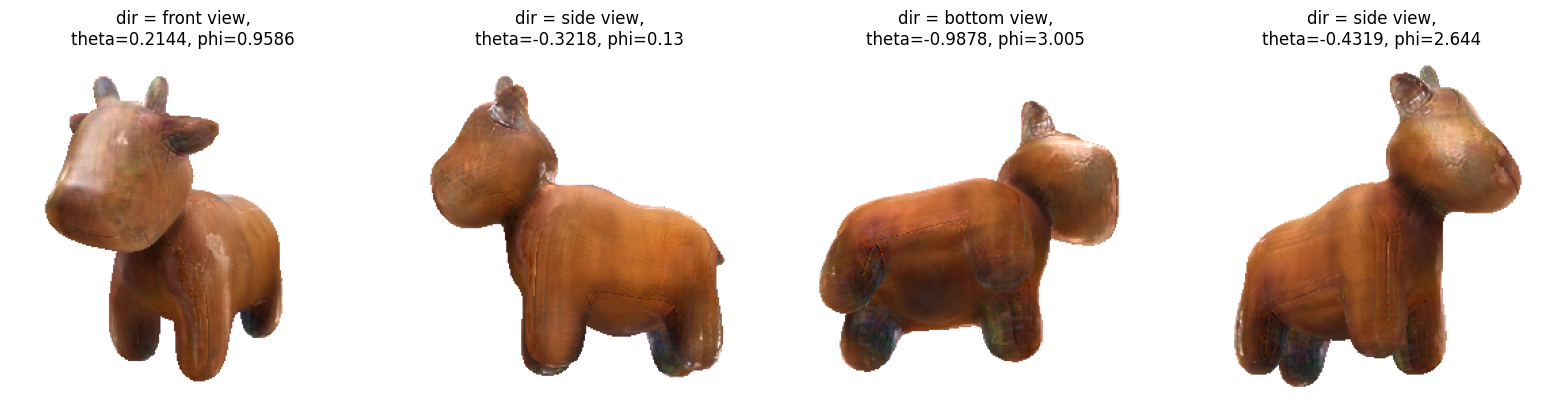

Training stage i: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


In [21]:
mesh_i, pbr_params_i = train_texture(
    mesh,
    pbr_params,
    prompt_embeddings,
    stage='i',
    n_iterations=500,
    learning_rate=0.01,
    batch_size=8,
    val_print_epoch=50,
    min_step=200,
    max_step=900,
    guidance_scale=15.0,
    device='cuda:0'
)

In [22]:
mesh_original = copy_mesh(mesh_i, pbr_params_i)

model_index.json:   0%|          | 0.00/692 [00:00<?, ?B/s]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[safety_checker/model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/pytorch_model.bin.index.fp16.json, text_encoder/model.safetensors.index.fp16.json, text_encoder/model.fp16-00001-of-00002.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

tokenizer/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/922M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Training stage ii:   0%|          | 0/250 [00:00<?, ?it/s]

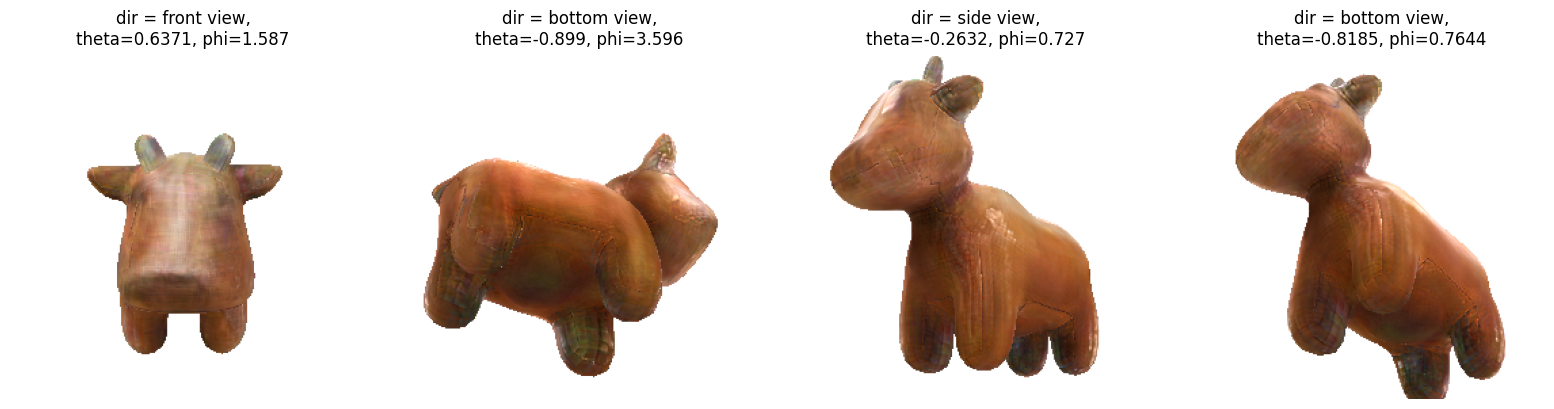

Training stage ii:  20%|██        | 50/250 [00:59<03:56,  1.18s/it]

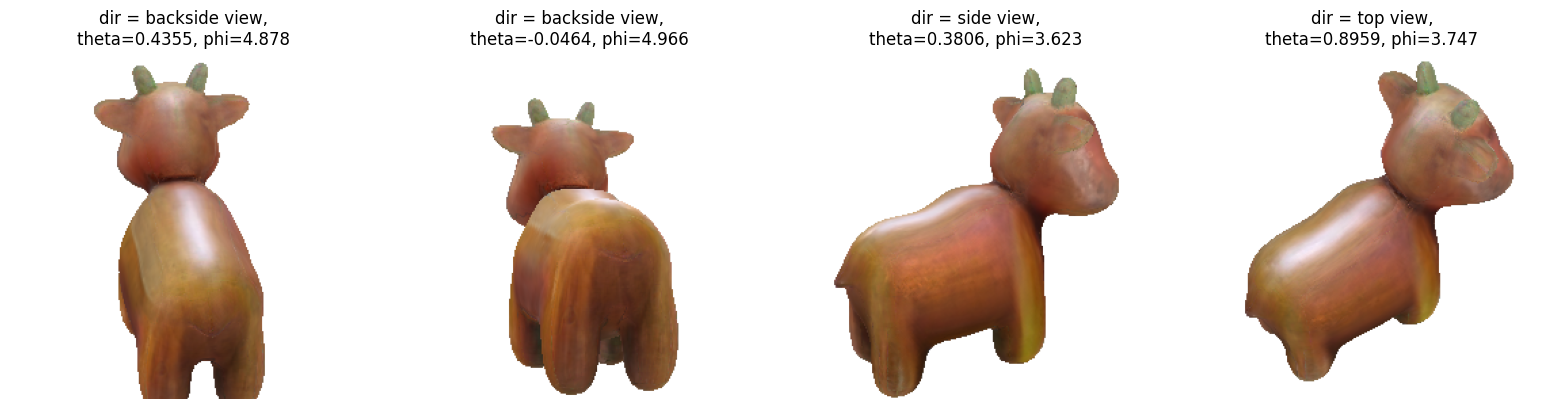

Training stage ii:  40%|████      | 100/250 [01:58<02:59,  1.19s/it]

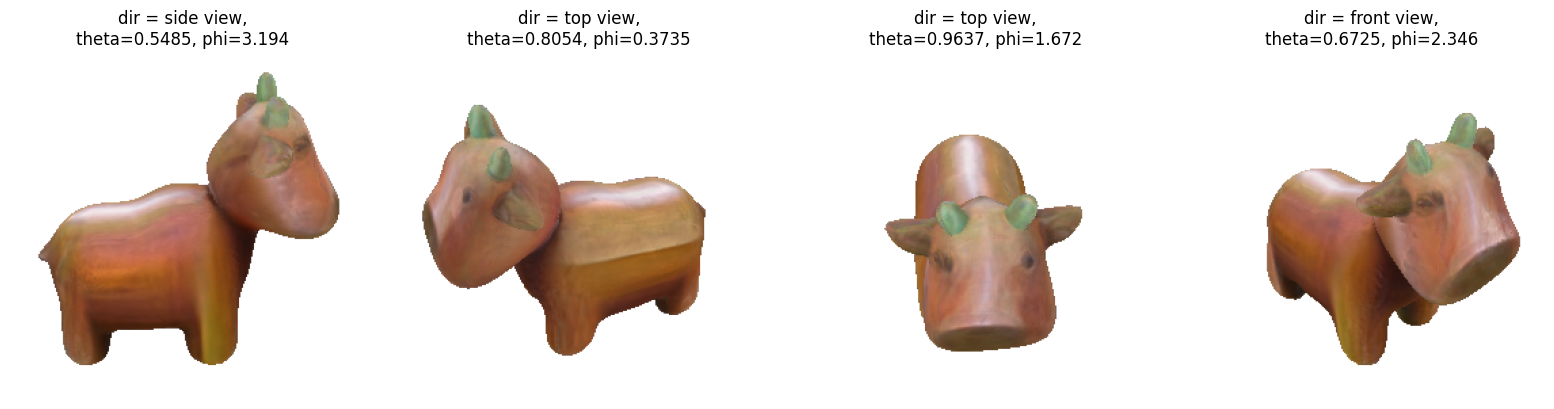

Training stage ii:  60%|██████    | 150/250 [02:58<01:58,  1.18s/it]

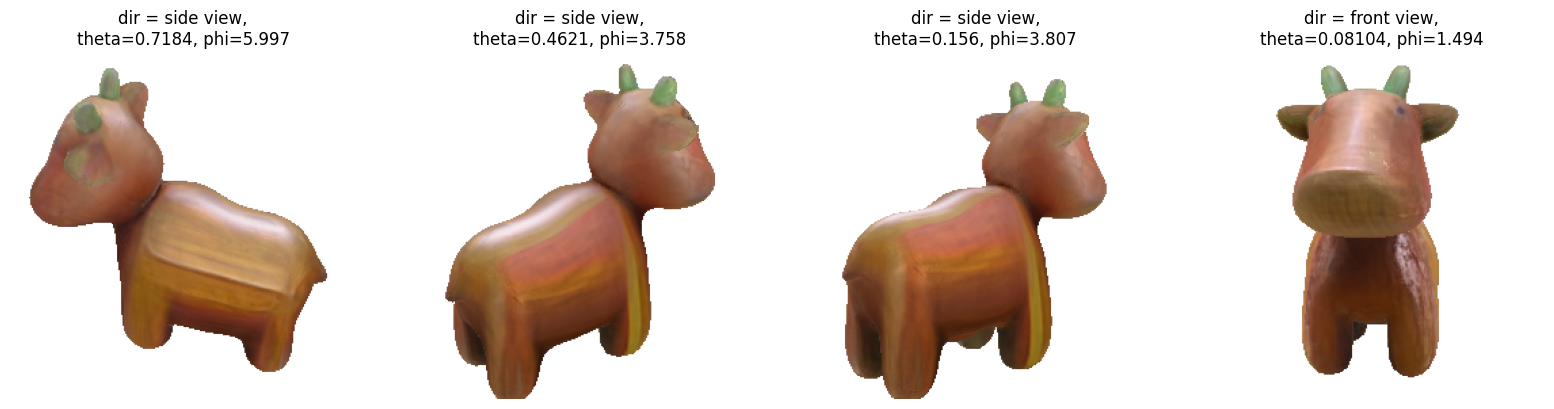

Training stage ii:  80%|████████  | 200/250 [03:58<00:59,  1.19s/it]

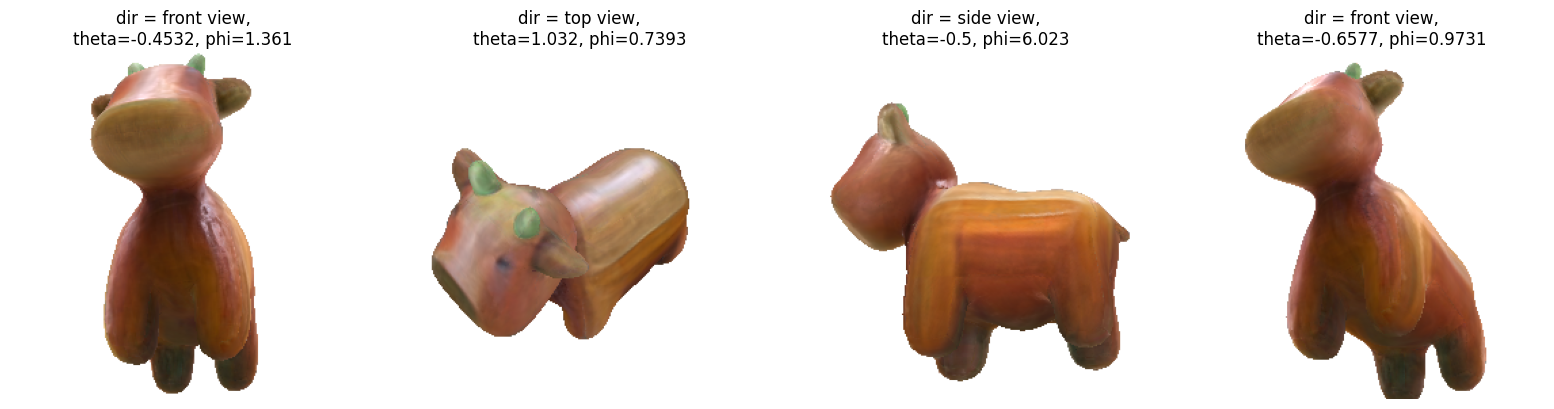

Training stage ii: 100%|██████████| 250/250 [04:58<00:00,  1.19s/it]


In [23]:
mesh_ii, pbr_params_ii = train_texture(
    mesh,
    pbr_params,
    prompt_embeddings,
    stage='ii',
    n_iterations=250,
    learning_rate=0.01,
    batch_size=4,
    val_print_epoch=50,
    min_step=200,
    max_step=900,
    guidance_scale=10.0,
    mesh_original=mesh_original,           # для stage ii
    lowres_noise_level=0.5,                # для stage ii
    device='cuda:0'
)

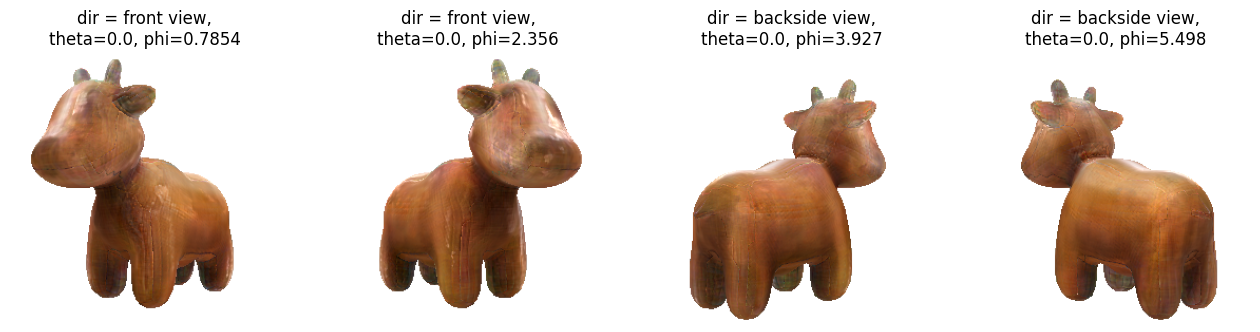

In [24]:
image = render(mesh_original, camera, light, val_background=True)
view_dirs = get_view_direction(camera_thetas, camera_phis)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(image[i].clamp(0., 1.).detach().cpu())
    ax.set_title(f"dir = {d2n[view_dirs[i].item()]},\ntheta={camera_thetas[i]:.4}, phi={camera_phis[i]:.4}")
    ax.axis('off')

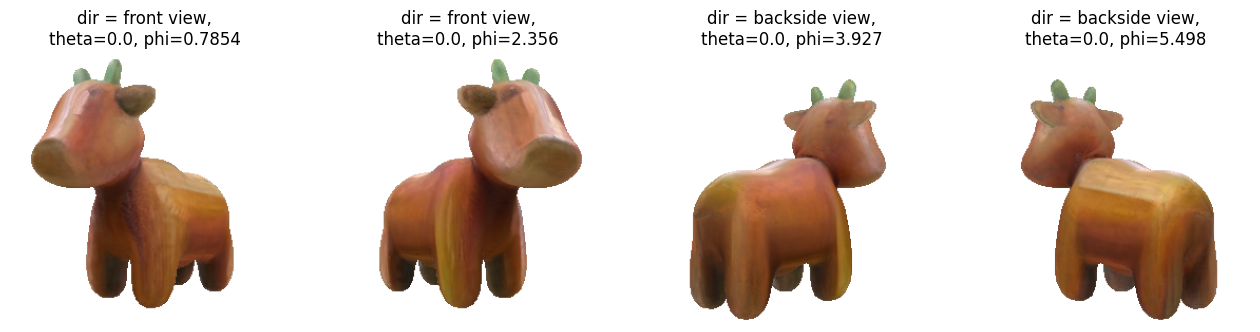

In [25]:
image = render(mesh_ii, camera, light, val_background=True)
view_dirs = get_view_direction(camera_thetas, camera_phis)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(image[i].clamp(0., 1.).detach().cpu())
    ax.set_title(f"dir = {d2n[view_dirs[i].item()]},\ntheta={camera_thetas[i]:.4}, phi={camera_phis[i]:.4}")
    ax.axis('off')